In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *
import json
from urllib.error import URLError,HTTPError
import time
from pathlib import Path

In [2]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    print(f'searching for {term}')
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

In [58]:
!rm -r "Deployment/cucumberzucchini"

In [4]:
# create DIR for notebook and set current DIR
NOTEBOOK_DIR = "Deployment/cucumberzucchini"
Path(NOTEBOOK_DIR).mkdir(parents=True, exist_ok=True)

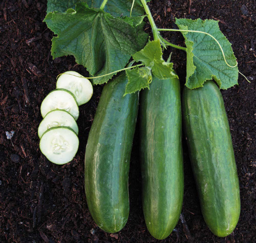

In [61]:
from fastdownload import download_url
from fastai.vision.all import *

dest = NOTEBOOK_DIR + '/cucumber.jpg'
urls = search_images_ddg("cucumber", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

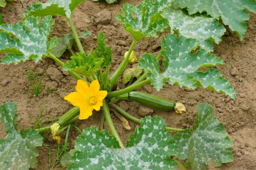

In [62]:
dest = NOTEBOOK_DIR + '/zucchini.jpg'
urls = search_images_ddg("zucchini photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

In [5]:
path = Path(NOTEBOOK_DIR+'/images')

In [60]:
searches = ['cucumber', 'zucchini']
path = Path(NOTEBOOK_DIR+'/images')

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{search} vegetable', max_images=50))
    time.sleep(10)
    resize_images(dest, max_size=400, dest=dest)
    print("Resized complete")
    
    
    

Resized complete
Resized complete


In [6]:
len(get_image_files(path))

121

In [7]:
# remove failed images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

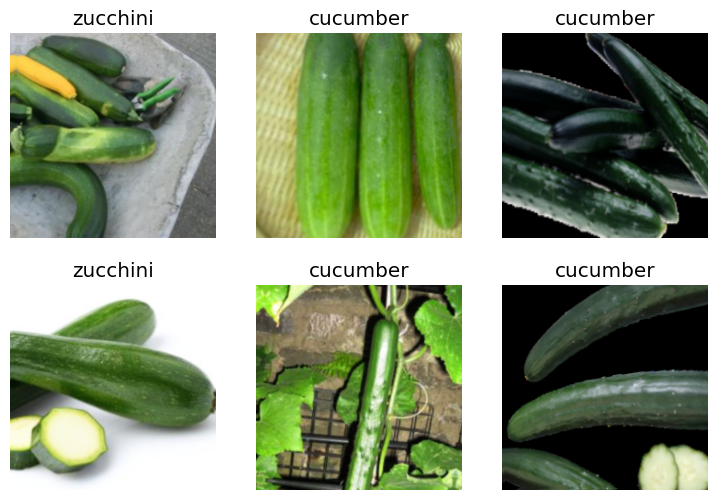

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)


In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/sachin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sachin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.225887,2.001863,0.500000,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.583430,0.927249,0.333333,00:27
1,0.490479,0.422705,0.208333,00:22
2,0.400447,0.321277,0.166667,00:24


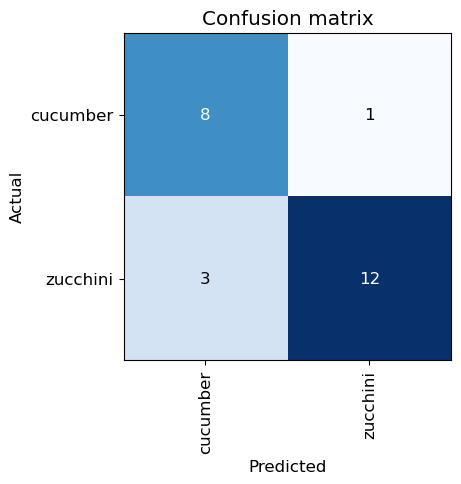

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

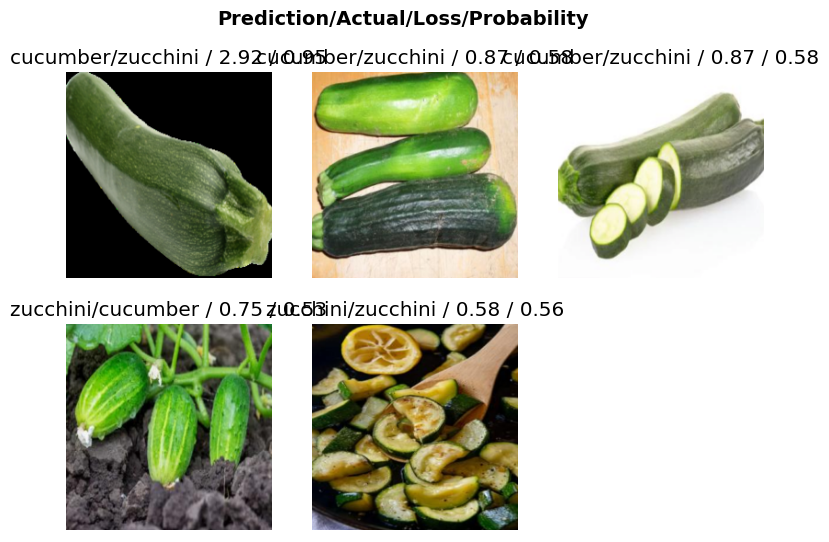

In [11]:
interp.plot_top_losses(5)

In [12]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [120]:
#hide
for idx in cleaner.delete(): 
    print(idx)
    cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): 
    print(idx, cat)
    shutil.move(str(cleaner.fns[idx]), path/cat)

0
5


In [11]:
def get_output(file_name):
    file_path = NOTEBOOK_DIR + f'/{file_name}'
    label,index,probs = learn.predict(PILImage.create(file_path))
    print(index)
    print(f"This is a {label}.")
    print(f"Probability it's a cucumber: {probs[0]:.4f}")
    print(f"Probability it's a zucchini: {probs[1]:.4f}")
    im = Image.open(file_path)
    return im.to_thumb(256, 256)

In [47]:
get_output('zucchini.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'Deployment/cucumberzucchini/zucchini.jpg'

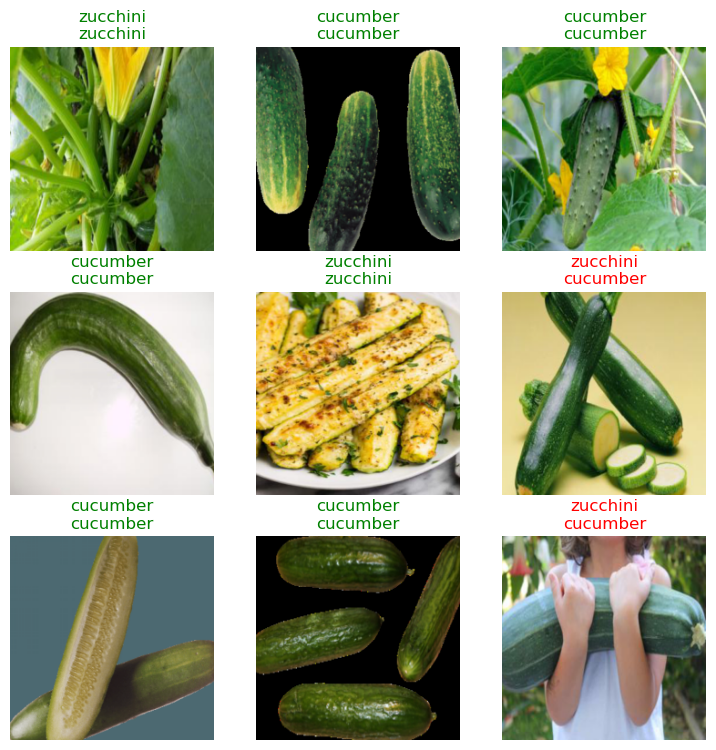

In [14]:
learn.show_results()